In [1]:
# Import packages to be used
import pandas as pd
import numpy as np
from urllib.request import urlopen
from bs4 import BeautifulSoup as bs

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
style.use('dark_background')
import warnings
warnings.filterwarnings('ignore')

### Scraping

In [2]:
# URLs to be scraped
url_2020 = 'https://fbref.com/en/squads/cff3d9bb/2020-2021/matchlogs/all_comps/schedule/Chelsea-Scores-and-Fixtures-All-Competitions'
url_2021 = 'https://fbref.com/en/squads/cff3d9bb/2021-2022/matchlogs/all_comps/schedule/Chelsea-Scores-and-Fixtures-All-Competitions'
url_2022 = 'https://fbref.com/en/squads/cff3d9bb/2022-2023/matchlogs/all_comps/schedule/Chelsea-Scores-and-Fixtures-All-Competitions'

In [3]:
# Open urls
r_20 = urlopen(url_2020)
r_21 = urlopen(url_2021)
r_22 = urlopen(url_2022)

In [4]:
# Create soup
soup_20 = bs(r_20, 'lxml')
soup_21 = bs(r_21, 'lxml')
soup_22 = bs(r_22, 'lxml')

In [5]:
# Extract header
headers = [th.getText() for th in soup_20.findAll('tr')[0].findAll('th')]

In [6]:
# Extract rows from table
rows_20 = soup_20.findAll('tr')[1:]
rows_21 = soup_21.findAll('tr')[1:]
rows_22 = soup_22.findAll('tr')[1:]

In [7]:
# Extract rows into a list
row_stats_20 = []
row_stats_21 = []
row_stats_22 = []
for i in range(len(rows_20)):
    row_stats_20.append([col.getText() for col in rows_20[i].findAll('td')])
for i in range(len(rows_21)):
    row_stats_21.append([col.getText() for col in rows_21[i].findAll('td')])
for i in range(len(rows_22)):
    row_stats_22.append([col.getText() for col in rows_22[i].findAll('td')])

In [8]:
# Extract dates into a list
row_date_20 = []
row_date_21 = []
row_date_22 = []
for i in range(len(rows_20)):
    row_date_20.append([col.getText() for col in rows_20[i].findAll('th')])
for i in range(len(rows_21)):
    row_date_21.append([col.getText() for col in rows_21[i].findAll('th')])
for i in range(len(rows_22)):
    row_date_22.append([col.getText() for col in rows_22[i].findAll('th')])

In [9]:
# Preview row data
print(row_stats_20[0])
print(row_stats_21[0])
print(row_stats_22[0])

['20:15 ', 'Premier League', 'Matchweek 1', 'Mon', 'Away', 'W', '3', '1', 'Brighton', '1.2', '1.4', '47', '', 'Jorginho', '4-2-2-2', 'Craig Pawson', 'Match Report', '']
['20:00 ', 'Super Cup', 'UEFA Super Cup', 'Wed', 'Home', 'D', '1 (6)', '1 (5)', 'es Villarreal', '', '', '62', '', "N'Golo Kanté", '3-4-3', 'Sergey Karasev', 'Match Report', '']
['17:30 ', 'Premier League', 'Matchweek 1', 'Sat', 'Away', 'W', '1', '0', 'Everton', '1.6', '0.5', '62', '39,254', 'César Azpilicueta', '3-4-3', 'Craig Pawson', 'Match Report', '']


In [10]:
# Create dataframe
df_20 = pd.DataFrame(row_stats_20, columns=headers[1:])
df_21 = pd.DataFrame(row_stats_21, columns=headers[1:])
df_22 = pd.DataFrame(row_stats_22, columns=headers[1:])

In [11]:
# Add date column and populate with list
df_1 = df_20.merge(df_20.drop_duplicates().assign(Date=row_date_20[0:]))
df_2 = df_21.merge(df_21.drop_duplicates().assign(Date=row_date_21[0:]))
df_3 = df_22.merge(df_22.drop_duplicates().assign(Date=row_date_22[0:]))

### Wrangling

In [12]:
# Select chelsea matches coached by TT
df_1 = df_1.drop(df_1.index[:29])
df_3 = df_3.drop(df_3.index[7:45])

In [13]:
# Concat dataframes
df_all = (df_1, df_2, df_3)
tt = pd.concat(df_all, ignore_index=True)

In [14]:
# Strip square brackets from date column
tt['Date'] = tt['Date'].str.get(0)

In [15]:
# Drop irrelevant columns
cols = ['Time', 'Referee', 'Match Report', 'Attendance', 'Notes', 'xG', 'xGA']
tt = tt.drop(cols, axis=1)

In [16]:
# Rename result values
tt['Result'] = tt['Result'].replace(['W', 'D', 'L'],['Win', 'Draw', 'Loss'])
tt['Comp'] = tt['Comp'].replace('Champions Lg', 'Champions League')

In [17]:
# Add lists containing fifa club wc matches to dataframe
tt.loc[99] = ['FIFA Club World Cup', 'Semi-finals', 'Wed', 'Neutral', 
                                          'Win', '1', '0', 'Al Hilal Riyadh', '61', 'César Azpilicueta', '3-4-3', '2022-02-09']
tt.loc[100] = ['FIFA Club World Cup', 'Final', 'Sat', 'Neutral', 'Win',
                 '2', '1', 'Palmeiras', '69', 'César Azpilicueta', '3-4-3', '2022-02-12']

In [18]:
# Convert date column to datetime datatype and sort by date
tt['Date'] = pd.to_datetime(tt['Date'])
tt = tt.sort_values(by='Date', ascending=True, ignore_index=True)

In [19]:
# Confirm changes
tt[tt['Comp'] == 'FIFA Club World Cup']

,Comp,Round,Day,Venue,Result,GF,GA,Opponent,Poss,Captain,Formation,Date
68,FIFA Club World Cup,Semi-finals,Wed,Neutral,Win,1,0,Al Hilal Riyadh,61,César Azpilicueta,3-4-3,2022-02-09
69,FIFA Club World Cup,Final,Sat,Neutral,Win,2,1,Palmeiras,69,César Azpilicueta,3-4-3,2022-02-12


In [20]:
# Convert possession column to int datatype
tt['Poss'] = tt['Poss'].astype(int)

In [21]:
# Add goals in parentheses to goals for consistency
tt['GF'] = ((tt['GF'].str.extract(r"\((.*?)\)", expand=False)).fillna(0).astype(int) + (tt['GF'].str[0]).astype(int))
tt['GA'] = ((tt['GA'].str.extract(r"\((.*?)\)", expand=False)).fillna(0).astype(int) + (tt['GA'].str[0]).astype(int))

In [22]:
# Get all clubs beginning with country code
cc = list(tt[tt.Opponent.str.istitle() == False].Opponent.unique())
print(cc)

['es Atlético Madrid', 'pt Porto', 'es Real Madrid', 'eng Manchester City', 'es Villarreal', 'ru Zenit', 'it Juventus', 'se Malmö', 'fr Lille', 'hr Dinamo Zagreb']


In [23]:
# Remove country codes
tt.loc[tt.Opponent.isin(cc), 'Opponent'] = tt['Opponent'].str.split().str[1:].str.join(' ')

In [24]:
# Convert Day and Venue into categorical datatypes
ordinal_var_dict = {'Day':['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'],
                   'Venue':['Home', 'Away', 'Neutral']}
for var in ordinal_var_dict:
    ordered_var = pd.api.types.CategoricalDtype(ordered=True, categories=ordinal_var_dict[var])
    tt[var] = tt[var].astype(ordered_var)

In [25]:
# Get matches decided by penalties
win = tt[tt.GF > tt.GA]
wins = win[win.Result == 'Draw']

lose = tt[tt.GF < tt.GA]
loss = lose[lose.Result == 'Draw']
wins

,Comp,Round,Day,Venue,Result,GF,GA,Opponent,Poss,Captain,Formation,Date
30,Super Cup,UEFA Super Cup,Wed,Home,Draw,7,6,Villarreal,62,N'Golo Kanté,3-4-3,2021-08-11
37,EFL Cup,Third round,Wed,Home,Draw,5,4,Aston Villa,68,N'Golo Kanté,4-3-3,2021-09-22
44,EFL Cup,Fourth round,Tue,Home,Draw,5,4,Southampton,63,Marcos Alonso,3-4-3,2021-10-26


In [26]:
# Change matches decided by penalties to either PK Win or PK Loss
tt.loc[wins.index, 'Result'] = 'Win'
tt.loc[loss.index, 'Result'] = 'Loss'

In [27]:
# Preview data head
tt.head(2)

,Comp,Round,Day,Venue,Result,GF,GA,Opponent,Poss,Captain,Formation,Date
0,Premier League,Matchweek 20,Wed,Home,Draw,0,0,Wolves,78,César Azpilicueta,4-2-3-1,2021-01-27
1,Premier League,Matchweek 21,Sun,Home,Win,2,0,Burnley,71,César Azpilicueta,3-4-3,2021-01-31


### Storage

In [28]:
# Store as csv
tt.to_csv('thomas_tuchel_scraped_cfc.csv', index=False, encoding='utf-8')

### Analysis

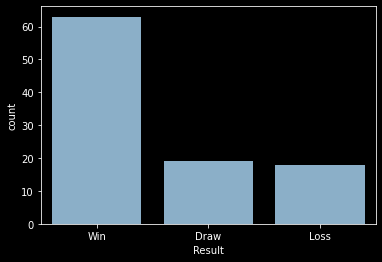

In [29]:
# Distribution of match results
base_color = sns.color_palette()[4]
result_order = tt.Result.value_counts().index
sns.countplot(data=tt, x='Result', color=base_color, order=result_order);

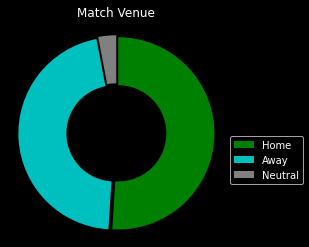

In [30]:
# Distribution of match venues
venue_counts = tt.Venue.value_counts()
explode = (0.02, 0.02, 0.02)
plt.pie(venue_counts, labels=None, explode=explode, startangle=90, counterclock=False, wedgeprops={'width':.5}, colors=('g','c','grey'))
plt.title('Match Venue')
plt.axis('square')
plt.legend(loc=2, labels=venue_counts.index, bbox_to_anchor=(1,0.5));

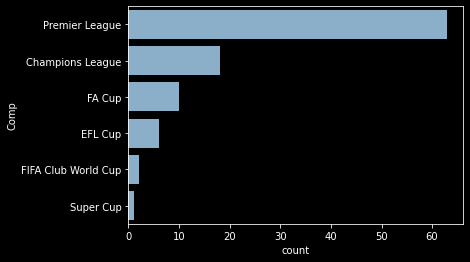

In [31]:
# Distribution of competitions
base_color = sns.color_palette()[4]
comp_order = tt.Comp.value_counts().index
sns.countplot(data=tt, y='Comp', color=base_color, order=comp_order);

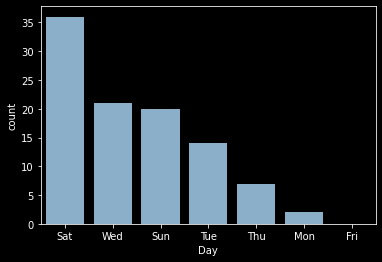

In [32]:
# Distribution of match day
base_color = sns.color_palette()[4]
day_order = tt.Day.value_counts().index
sns.countplot(data=tt, x='Day', color=base_color, order=day_order);

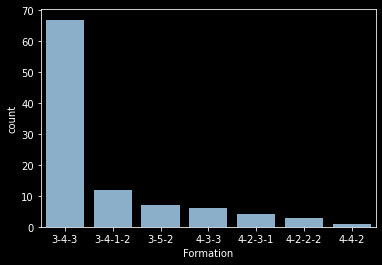

In [33]:
# Disribution of team formation
base_color = sns.color_palette()[4]
form_order = tt.Formation.value_counts().index
sns.countplot(data=tt, x='Formation', color=base_color, order=form_order);

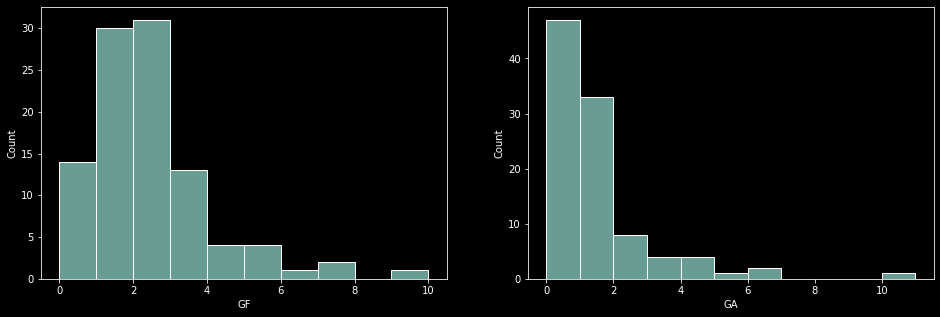

In [34]:
# Distribution of goals for and goals against chelsea
plt.figure(figsize=(16,5))
plt.subplot(1, 2, 1)
bins = np.arange(0, tt.GF.max()+1, 1)
sns.histplot(tt.GF, bins=bins);

plt.subplot(1, 2, 2)
bins_ga = np.arange(0, tt.GA.max()+1, 1)
sns.histplot(tt.GA, bins=bins_ga);

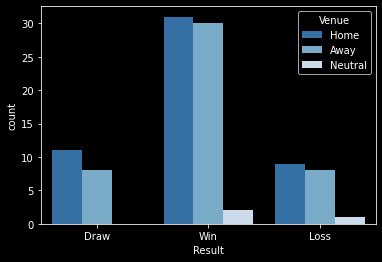

In [35]:
# Result by venue
sns.countplot(data=tt, x='Result', hue='Venue', palette='Blues_r');

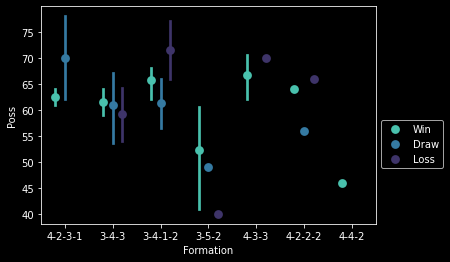

In [36]:
# Chelsea formation by possession by match results
result_order = tt.Result.value_counts().index
sns.pointplot(data=tt, x='Formation', y='Poss', hue='Result', hue_order=result_order, palette='mako_r', linestyles='', dodge=0.4)
plt.legend(bbox_to_anchor=(1,0.5));

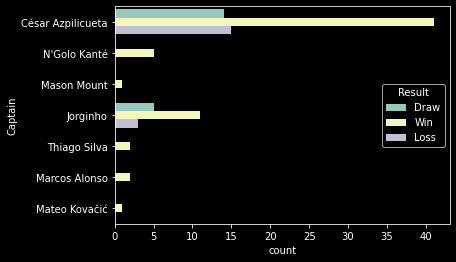

In [37]:
# Match results by team captain
sns.countplot(data=tt, y='Captain', hue='Result');

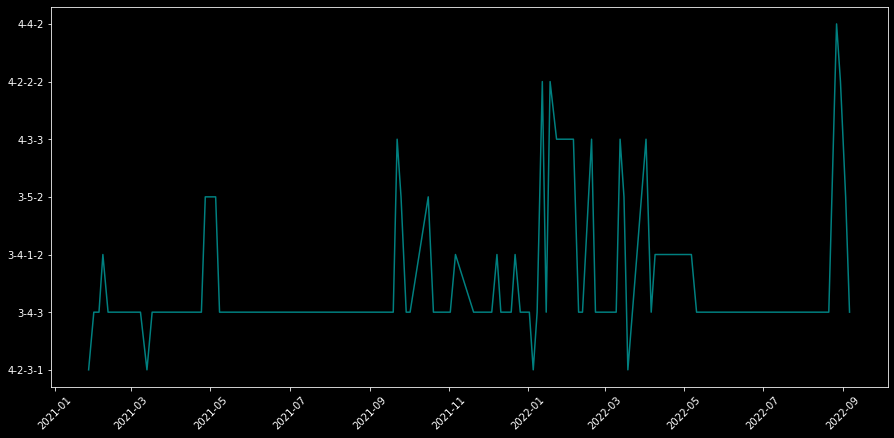

In [38]:
# Formation used over time
plt.figure(figsize=(15,7))
plt.plot(tt.Date, tt.Formation, color='teal')
plt.xticks(rotation=45)
plt.show()

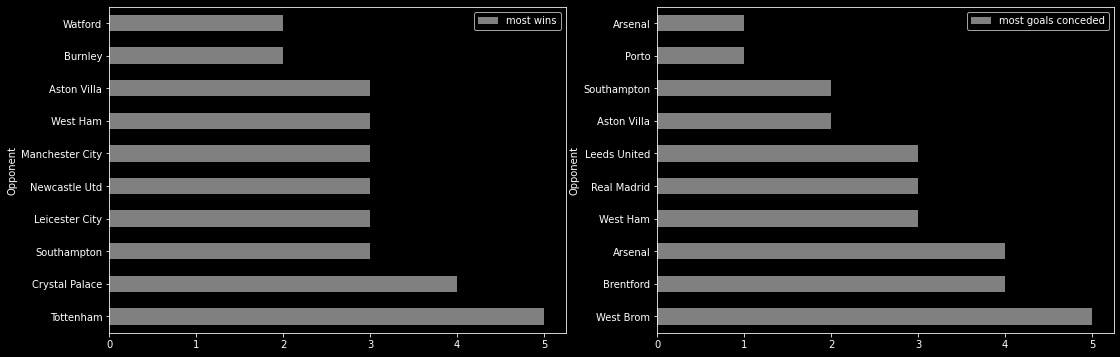

In [39]:
# Most goals conceded and club defeated the most
win = tt[tt.Result == 'Win']
loss = tt[tt.Result == 'Loss']

fig, axes = plt.subplots(nrows=1, ncols=2, sharey='col', figsize=(18,6))
most_wins = win.groupby('Opponent').Formation.count().reset_index(name='count').sort_values('count',ascending=False).head(10)
most_goals_conceded = loss.groupby(['Opponent', 'GA']).Formation.count().reset_index(name='count').sort_values('GA',ascending=False)[2:].head(10)
plt.subplot(1, 2, 1)
most_wins.plot.barh(ax=axes[0], x='Opponent', y='count', label='most wins', width=0.5, color='grey');
plt.subplot(1 ,2 ,2)
most_goals_conceded.plot.barh(ax=axes[1], x='Opponent', y='GA', label='most goals conceded', width=0.5, color='grey');

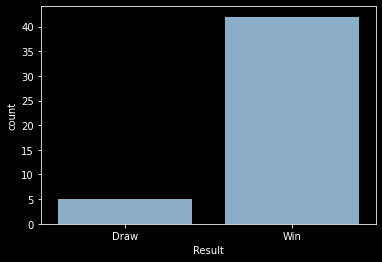

In [40]:
# Number of clean sheets
clean_sheets = tt[tt.GA == 0]
base_color = sns.color_palette()[4]
sns.countplot(data=clean_sheets, x='Result', color=base_color);

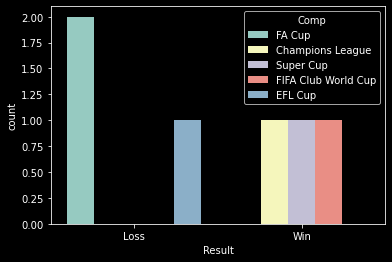

In [41]:
# Finals reached
finals = tt[(tt['Round'].str.contains('Final')) | (tt['Round'].str.contains('Super'))]
sns.countplot(data=finals, x='Result', hue='Comp', orient='v');

In [42]:
# Average goals scored and conceded
avg_goals_scored = tt.GF.sum() / tt.GF.count()
avg_goals_conceded = tt.GA.sum() / tt.GA.count()

print(avg_goals_scored)
print(avg_goals_conceded)

1.97
1.05
